In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10829193123834747168, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10073476783347958625
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np
np.random.seed(777)

import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from tqdm import tqdm

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [5]:
output_classes = 2
# batch_size = 4 
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 20

nb_train_samples = 386
nb_validation_samples = 199
nb_test_samples = 155

In [6]:
train_dir = 'data_reduced/train/'
validation_dir = 'data_reduced/validation'
test_dir = 'data_reduced/test'

In [7]:
random_seed = np.random.seed(777)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 386 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


# First OnTop Model

In [16]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

inceptV3_net = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

model = Sequential()
model.add(inceptV3_net)
model.add(GlobalAveragePooling2D(name='global_avg_pool'))
model.add(Dense(output_classes, activation='softmax', name='classifier'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 2048)              0         
_________________________________________________________________
classifier (Dense)           (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [18]:
net = model.layers[0] # show the inceptV3_net layers
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 111, 111, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_238 (Activation)     (None, 111, 111, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 25, 25, 256)  0           activation_243[0][0]             
                                                                 activation_245[0][0]             
                                                                 activation_248[0][0]             
                                                                 activation_249[0][0]             
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 25, 25, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 25, 25, 64)   192         conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 25, 25, 64)   192         conv2d_208[0][0]                 
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 25, 25, 64)   192         conv2d_210[0][0]                 
__________________________________________________________________________________________________
batch_normalization_213 (BatchN (None, 25, 25, 96)   288         conv2d_213[0][0]                 
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 25, 25, 64)   192         conv2d_214[0][0]                 
__________________________________________________________________________________________________
activation_257 (Activation)     (None, 25, 25, 64)   0           batch_normalization_208[0][0]    
__________

batch_normalization_226 (BatchN (None, 12, 12, 128)  384         conv2d_226[0][0]                 
__________________________________________________________________________________________________
activation_270 (Activation)     (None, 12, 12, 128)  0           batch_normalization_221[0][0]    
__________________________________________________________________________________________________
activation_275 (Activation)     (None, 12, 12, 128)  0           batch_normalization_226[0][0]    
__________________________________________________________________________________________________
average_pooling2d_22 (AveragePo (None, 12, 12, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 12, 12, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_222

__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 12, 12, 192)  576         conv2d_229[0][0]                 
__________________________________________________________________________________________________
batch_normalization_232 (BatchN (None, 12, 12, 192)  576         conv2d_232[0][0]                 
__________________________________________________________________________________________________
batch_normalization_237 (BatchN (None, 12, 12, 192)  576         conv2d_237[0][0]                 
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 12, 12, 192)  576         conv2d_238[0][0]                 
__________________________________________________________________________________________________
activation_278 (Activation)     (None, 12, 12, 192)  0           batch_normalization_229[0][0]    
__________

activation_297 (Activation)     (None, 12, 12, 192)  0           batch_normalization_248[0][0]    
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 12, 12, 768)  0           activation_288[0][0]             
                                                                 activation_291[0][0]             
                                                                 activation_296[0][0]             
                                                                 activation_297[0][0]             
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 12, 12, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_253 (BatchN (None, 12, 12, 192)  576         conv2d_253[0][0]                 
__________

batch_normalization_262 (BatchN (None, 12, 12, 192)  576         conv2d_262[0][0]                 
__________________________________________________________________________________________________
activation_311 (Activation)     (None, 12, 12, 192)  0           batch_normalization_262[0][0]    
__________________________________________________________________________________________________
conv2d_259 (Conv2D)             (None, 12, 12, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 12, 12, 192)  258048      activation_311[0][0]             
__________________________________________________________________________________________________
batch_normalization_259 (BatchN (None, 12, 12, 192)  576         conv2d_259[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_321 (Activation)     (None, 5, 5, 384)    0           batch_normalization_272[0][0]    
__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, 5, 5, 192)    576         conv2d_273[0][0]                 
__________________________________________________________________________________________________
activation_314 (Activation)     (None, 5, 5, 320)    0           batch_normalization_265[0][0]    
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 5, 5, 768)    0           activation_316[0][0]             
                                                                 activation_317[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 5, 5, 768)    0           activation_320[0][0]             
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_6[0][0]              
                                                                 activation_331[0][0]             
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


# Second OnTop Model

In [20]:
# Define second model ontop of the first model for the bottleneck features using a GAP layer
x = GlobalAveragePooling2D()(net.get_layer('mixed10').output) # 310 is the last inception layer
bottleneck_model = Model(net.get_layer('input_4').input, x, name='inception_v3_bottleneck')

# This list is as long as Inception's
bottleneck_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 111, 111, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_238 (Activation)     (None, 111, 111, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 25, 25, 256)  0           activation_243[0][0]             
                                                                 activation_245[0][0]             
                                                                 activation_248[0][0]             
                                                                 activation_249[0][0]             
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 25, 25, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 25, 25, 64)   192         conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 25, 25, 64)   192         conv2d_208[0][0]                 
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 25, 25, 64)   192         conv2d_210[0][0]                 
__________________________________________________________________________________________________
batch_normalization_213 (BatchN (None, 25, 25, 96)   288         conv2d_213[0][0]                 
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 25, 25, 64)   192         conv2d_214[0][0]                 
__________________________________________________________________________________________________
activation_257 (Activation)     (None, 25, 25, 64)   0           batch_normalization_208[0][0]    
__________

batch_normalization_226 (BatchN (None, 12, 12, 128)  384         conv2d_226[0][0]                 
__________________________________________________________________________________________________
activation_270 (Activation)     (None, 12, 12, 128)  0           batch_normalization_221[0][0]    
__________________________________________________________________________________________________
activation_275 (Activation)     (None, 12, 12, 128)  0           batch_normalization_226[0][0]    
__________________________________________________________________________________________________
average_pooling2d_22 (AveragePo (None, 12, 12, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 12, 12, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_222

__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 12, 12, 192)  576         conv2d_229[0][0]                 
__________________________________________________________________________________________________
batch_normalization_232 (BatchN (None, 12, 12, 192)  576         conv2d_232[0][0]                 
__________________________________________________________________________________________________
batch_normalization_237 (BatchN (None, 12, 12, 192)  576         conv2d_237[0][0]                 
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 12, 12, 192)  576         conv2d_238[0][0]                 
__________________________________________________________________________________________________
activation_278 (Activation)     (None, 12, 12, 192)  0           batch_normalization_229[0][0]    
__________

activation_297 (Activation)     (None, 12, 12, 192)  0           batch_normalization_248[0][0]    
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 12, 12, 768)  0           activation_288[0][0]             
                                                                 activation_291[0][0]             
                                                                 activation_296[0][0]             
                                                                 activation_297[0][0]             
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 12, 12, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_253 (BatchN (None, 12, 12, 192)  576         conv2d_253[0][0]                 
__________

batch_normalization_262 (BatchN (None, 12, 12, 192)  576         conv2d_262[0][0]                 
__________________________________________________________________________________________________
activation_311 (Activation)     (None, 12, 12, 192)  0           batch_normalization_262[0][0]    
__________________________________________________________________________________________________
conv2d_259 (Conv2D)             (None, 12, 12, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 12, 12, 192)  258048      activation_311[0][0]             
__________________________________________________________________________________________________
batch_normalization_259 (BatchN (None, 12, 12, 192)  576         conv2d_259[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_321 (Activation)     (None, 5, 5, 384)    0           batch_normalization_272[0][0]    
__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, 5, 5, 192)    576         conv2d_273[0][0]                 
__________________________________________________________________________________________________
activation_314 (Activation)     (None, 5, 5, 320)    0           batch_normalization_265[0][0]    
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 5, 5, 768)    0           activation_316[0][0]             
                                                                 activation_317[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 5, 5, 768)    0           activation_320[0][0]             
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_6[0][0]              
                                                                 activation_331[0][0]             
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           mixed10[0][0]                    
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [ ]:
# svm_bottleneck should connect to the output of bottleneck_model, thus training based on image features.
svm_bottleneck = SVC(C=1.0, gamma='auto', probability=True, tol=0.001, verbose=False, decision_function_shape='ovr')

# svm_net should connect to the output of full_model, thus training on the output of the deep model.
svm_net = SVC(C=1.0, gamma='auto', probability=False, tol=0.001, verbose=False, decision_function_shape='ovr'

In [21]:
X_train, y_train = [], []
for _ in tqdm(range(nb_train_samples)):
    x, y = train_generator.next()
    X_train.append(x[0])
    y_train.append(y[0])
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
y_train = np.argmax(y_train, axis=1)
# np.save('data/npy/X_train.npy', X_train)
# np.save('data/npy/y_train.npy', y_train)

100%|███████████████████████████████████████████████████████████████████████████████| 386/386 [00:00<00:00, 390.69it/s]


In [22]:
X_train = np.array([x.flatten() for x in X_train])

In [23]:
X_validation, y_validation = [], []
for _ in tqdm(range(nb_validation_samples)):
    x_val, y_val = validation_generator.next()
    X_validation.append(x_val[0])
    y_validation.append(y_val[0])
X_validation = np.asarray(X_validation)
y_validation = np.asarray(y_validation)
y_validation = np.argmax(y_validation, axis=1)
# np.save('data/npy/X_validation.npy', X_validation)
# np.save('data/npy/y_validation.npy', y_validation)

100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 195.68it/s]


In [24]:
X_validation = np.array([x.flatten() for x in X_validation])

In [25]:
X_test, y_test = [], []
for _ in tqdm(range(nb_test_samples)):
    x_t, y_t = test_generator.next()
    X_test.append(x_t[0])
    y_test.append(y_t[0])
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test, axis=1)
# np.save('data/npy/X_test.npy', X_test)
# np.save('data/npy/y_test.npy', y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 198.16it/s]


In [26]:
X_test = np.array([x.flatten() for x in X_test])

In [27]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# plt.imshow(X_train[0])
# plt.show()

X_train shape: (386, 150528)
y_train shape: (386,)
X_validation shape: (199, 150528)
y_validation shape: (199,)
X_test shape: (155, 150528)
y_test shape: (155,)


Estimated p =  0.5


(0.5, 0.3134715025906736)

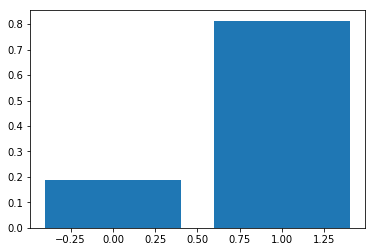

In [28]:
#class_distrib_train = np.array(np.sum(train_1hot, axis=0)).flatten()
class_distrib_train = np.histogram(y_train, bins=np.arange(0, 1 + output_classes))[0]

plt.bar(np.arange(len(class_distrib_train)), class_distrib_train/np.sum(class_distrib_train))
# plt.savefig('img/bottleneck_train_distrib.png')
print('Estimated p = ', 1/output_classes)

class_density_train = class_distrib_train / np.sum(class_distrib_train)

np.mean(class_density_train), np.std(class_density_train)

Estimated p =  0.5


(0.5, 0.017587939698492483)

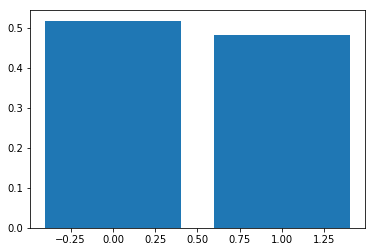

In [30]:
#class_distrib_val = np.array(np.sum(val_1hot, axis=0)).flatten()
class_distrib_val = np.histogram(y_validation, bins=np.arange(0, 1 + output_classes))[0]

plt.bar(np.arange(len(class_distrib_val)), class_distrib_val/np.sum(class_distrib_val))
# plt.savefig('img/bottleneck_val_distrib.png')
print('Estimated p = ', 1/output_classes)

class_density_val = class_distrib_val / np.sum(class_distrib_val)

np.mean(class_density_val), np.std(class_density_val)

In [33]:
np.savez('models/bottleneck_datasets.npz', X_train, y_train, X_validation, y_validation)

In [34]:
data = np.load('models/bottleneck_datasets.npz')

train_x = data['arr_0']
train_y = data['arr_1']
val_x = data['arr_2']
val_y = data['arr_3']

train_x.shape, train_y.shape, val_x.shape, val_y.shape

((386, 150528), (386,), (199, 150528), (199,))

## PCA
### Dimensionality reduction (in case 2048 features is too much) via PCA and LDA

In [37]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 95% energy was in 200 dimensions or so
pca = PCA(n_components=200)

pca.fit(train_x)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0.95290935, 200)

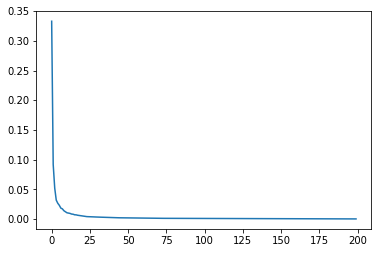

In [38]:
n_feats = 200

plt.plot(range(len(pca.explained_variance_ratio_[:n_feats])), pca.explained_variance_ratio_[:n_feats])

np.sum(pca.explained_variance_ratio_[:n_feats]), len(pca.explained_variance_)

In [41]:
# 95% of energy in 68 dimensions or so
lda = LinearDiscriminantAnalysis(n_components=68)

lda.fit(train_x, train_y)

LinearDiscriminantAnalysis(n_components=68, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

(1.0, 1)

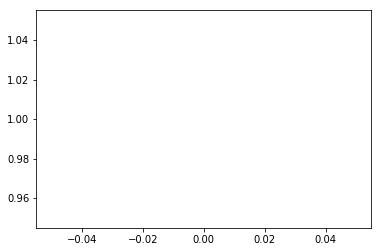

In [42]:
n_feats = 68
plt.plot(range(len(lda.explained_variance_ratio_[:n_feats])), lda.explained_variance_ratio_[:n_feats])
np.sum(lda.explained_variance_ratio_[:n_feats]), len(lda.explained_variance_ratio_)

In [43]:
train_x_pca = pca.transform(train_x)
train_x_lda = lda.transform(train_x)

train_x_pca.shape, train_x_lda.shape

((386, 200), (386, 1))

____

### SVM 5-fold Crossvalidation w/ acc and f1 (all features, pca or lda)

In [58]:
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# f1_micro, f1_macro, f1_weighted
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro'}

svm_bottleneck = SVC(C=1.0, gamma='auto', probability=True, tol=0.001, verbose=False, decision_function_shape='ovr')

'''
svm_bottleneck = LinearSVC(
    penalty='l2',
    loss='squared_hinge',
    tol=0.0001,
    C=1.0,
    multi_class='ovr',
    verbose=0,
    max_iter=1000
)
'''

t0 = time.time()
scores = cross_validate(svm_bottleneck, train_x, train_y, scoring=scoring, cv=5, 
                        return_train_score=True, n_jobs=3, verbose=1)
# with dimensionality reduction
#scores = cross_validate(svm_bottleneck, train_x_pca, train_y, scoring=scoring, cv=5, return_train_score=True, n_jobs=3, verbose=1)
#scores = cross_validate(svm_bottleneck, train_x_lda, train_y, scoring=scoring, cv=5, return_train_score=True, n_jobs=3, verbose=1)

print('finished in %.2fs' % (time.time() - t0))

print('Models took an average %ds to train and another %ds to score' % 
      (np.mean(scores['fit_time']), np.mean(scores['score_time'])))

print('Average accuracy was %.3f +- %.3f during training' % 
      (np.mean(scores['train_accuracy']), np.std(scores['train_accuracy'])))

print('Average accuracy was %.3f +- %.3f during testing' % 
      (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

print('Average F1 was %.3f +- %.3f during training' % 
      (np.mean(scores['train_f1']), np.std(scores['train_f1'])))

print('Average F1 was %.3f +- %.3f during testing' % 
      (np.mean(scores['test_f1']), np.std(scores['test_f1'])))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.4min finished


finished in 85.90s
Models took an average 27s to train and another 2s to score
Average accuracy was 0.905 +- 0.017 during training
Average accuracy was 0.899 +- 0.025 during testing
Average F1 was 0.810 +- 0.043 during training
Average F1 was 0.790 +- 0.067 during testing


## SVM train (RBF for probs, LDA feats)

In [50]:
from keras.utils import plot_model
plot_model(bottleneck_model, to_file='inceptionv3_notop.png')
plot_model(full_model, to_file='inceptionv3_full.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [51]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 111, 111, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_238 (Activation)     (None, 111, 111, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 25, 25, 256)  0           activation_243[0][0]             
                                                                 activation_245[0][0]             
                                                                 activation_248[0][0]             
                                                                 activation_249[0][0]             
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 25, 25, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 25, 25, 64)   192         conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 25, 25, 64)   192         conv2d_208[0][0]                 
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 25, 25, 64)   192         conv2d_210[0][0]                 
__________________________________________________________________________________________________
batch_normalization_213 (BatchN (None, 25, 25, 96)   288         conv2d_213[0][0]                 
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 25, 25, 64)   192         conv2d_214[0][0]                 
__________________________________________________________________________________________________
activation_257 (Activation)     (None, 25, 25, 64)   0           batch_normalization_208[0][0]    
__________

batch_normalization_226 (BatchN (None, 12, 12, 128)  384         conv2d_226[0][0]                 
__________________________________________________________________________________________________
activation_270 (Activation)     (None, 12, 12, 128)  0           batch_normalization_221[0][0]    
__________________________________________________________________________________________________
activation_275 (Activation)     (None, 12, 12, 128)  0           batch_normalization_226[0][0]    
__________________________________________________________________________________________________
average_pooling2d_22 (AveragePo (None, 12, 12, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 12, 12, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_222

__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 12, 12, 192)  576         conv2d_229[0][0]                 
__________________________________________________________________________________________________
batch_normalization_232 (BatchN (None, 12, 12, 192)  576         conv2d_232[0][0]                 
__________________________________________________________________________________________________
batch_normalization_237 (BatchN (None, 12, 12, 192)  576         conv2d_237[0][0]                 
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 12, 12, 192)  576         conv2d_238[0][0]                 
__________________________________________________________________________________________________
activation_278 (Activation)     (None, 12, 12, 192)  0           batch_normalization_229[0][0]    
__________

activation_297 (Activation)     (None, 12, 12, 192)  0           batch_normalization_248[0][0]    
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 12, 12, 768)  0           activation_288[0][0]             
                                                                 activation_291[0][0]             
                                                                 activation_296[0][0]             
                                                                 activation_297[0][0]             
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 12, 12, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_253 (BatchN (None, 12, 12, 192)  576         conv2d_253[0][0]                 
__________

batch_normalization_262 (BatchN (None, 12, 12, 192)  576         conv2d_262[0][0]                 
__________________________________________________________________________________________________
activation_311 (Activation)     (None, 12, 12, 192)  0           batch_normalization_262[0][0]    
__________________________________________________________________________________________________
conv2d_259 (Conv2D)             (None, 12, 12, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 12, 12, 192)  258048      activation_311[0][0]             
__________________________________________________________________________________________________
batch_normalization_259 (BatchN (None, 12, 12, 192)  576         conv2d_259[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_321 (Activation)     (None, 5, 5, 384)    0           batch_normalization_272[0][0]    
__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, 5, 5, 192)    576         conv2d_273[0][0]                 
__________________________________________________________________________________________________
activation_314 (Activation)     (None, 5, 5, 320)    0           batch_normalization_265[0][0]    
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 5, 5, 768)    0           activation_316[0][0]             
                                                                 activation_317[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 5, 5, 768)    0           activation_320[0][0]             
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_6[0][0]              
                                                                 activation_331[0][0]             
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [52]:
'''
svm_bottleneck = SVC(
    C=1.0,
    gamma='auto',
    probability=True,
    tol=0.001,
    verbose=False,
    decision_function_shape='ovr'
)
'''
svm_bottleneck = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.0001, C=1.0, 
                           multi_class='ovr', verbose=0, max_iter=1000)


t0 = time.time()
#svm_bottleneck.fit(train_x_lda, train_y) # 86 89
svm_bottleneck.fit(train_x_pca, train_y) # 95 94
#svm_bottleneck.fit(train_x, train_y) # 94 94
print('finished in %.1fs' % (time.time() - t0))

#val_x_lda = lda.transform(val_x)
#svm_preds = svm_bottleneck.predict(val_x_lda)
val_x_pca = pca.transform(val_x)
svm_preds = svm_bottleneck.predict(val_x_pca)
#svm_preds = svm_bottleneck.predict(val_x)

accuracy_score(val_y, svm_preds), f1_score(val_y, svm_preds, average='macro')

finished in 0.1s


(0.6683417085427136, 0.6469354838709678)

In [60]:
# fit on train data
t0 = time.time()
svm_bottleneck.fit(train_x, train_y)
print('finished in %.2fs' % (time.time() - t0))

finished in 39.92s


In [61]:
t0 = time.time()
preds = svm_bottleneck.predict(val_x)
print('finished in %.2fs' % (time.time() - t0))

finished in 4.69s


In [62]:
t0 = time.time()
preds_prob = svm_bottleneck.predict_proba(val_x)
print('finished in %.2fs' % (time.time() - t0))

finished in 4.41s


In [63]:
preds_prob[0]

array([1.62043778e-05, 9.99983796e-01])

In [64]:
# test on validation data
t0 = time.time()
preds = svm_bottleneck.predict(val_x)
print('finished in %.2fs' % (time.time() - t0))

t0 = time.time()
acc = accuracy_score(val_y, preds)
print('finished in %.2fs' % (time.time() - t0))

t0 = time.time()
f1 = f1_score(val_y, preds, average='macro')
print('finished in %.2fs' % (time.time() - t0))

acc, f1

finished in 4.57s
finished in 0.00s
finished in 0.00s


(0.6030150753768844, 0.5432199203881803)

In [65]:
# saving a backup of the previously trained svm just in case
svm_bottleneck_bottleneck = svm_bottleneck

### Predict on Test Set

In [68]:
val_x_lda = lda.transform(X_validation)


svms = [SVC(C=1.0, gamma='auto', probability=True, tol=0.001, 
            verbose=False, decision_function_shape='ovr') for _ in range(3)]

t0 = time.time()
svms[0].fit(train_x_lda, train_y) # 
svms[1].fit(train_x_pca, train_y) # 
svms[2].fit(train_x, train_y)     # 
print('finished in %.1fs' % (time.time() - t0))

test_x_lda = lda.transform(X_test)
test_x_pca = pca.transform(X_test)

lda_preds  = svms[0].predict(val_x_lda)
pca_preds  = svms[1].predict(val_x_pca)
nodr_preds = svms[2].predict(val_x)

print(accuracy_score(val_y, lda_preds), f1_score(val_y, lda_preds, average='macro'))
print(accuracy_score(val_y, pca_preds), f1_score(val_y, pca_preds, average='macro'))
print(accuracy_score(val_y, nodr_preds), f1_score(val_y, nodr_preds, average='macro'))

finished in 40.8s
0.5577889447236181 0.5568825910931174
0.4824120603015075 0.32542372881355935
0.6030150753768844 0.5432199203881803


In [69]:
# RBF SVC variance estimated s^2 = (0.003)^2

def inverse_variance_weighting(predictions, variances):
    if len(predictions) != len(variances):
        print('Precictions-variances mismatch.')
        sys.exit(0)
    
    aa = np.sum(np.divide(predictions, variances))
    bb = 1 / np.sum(variances)
    
    return aa / bb

In [72]:
voting_clf = VotingClassifier([model, svm_bottleneck])  # (inception model (first top model))
voting_clf 

VotingClassifier(estimators=[<keras.engine.sequential.Sequential object at 0x00000171DD2AEA20>, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [ ]:
# # open sved history
# with open('inception_v3_spoton.historydf.pickle', 'rb') as f:
#     historydf = pickle.load(f)

# historydf

In [ ]:
# acc = historydf['categorical_accuracy']
# val_acc = historydf['val_categorical_accuracy']
# loss = historydf['loss']
# val_loss = historydf['val_loss']

# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.savefig('img/inception_acc.png')

# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.savefig('img/inception_loss.png')
 
# plt.show()